In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg

In [2]:
images_folder_path = './images'

In [3]:
def load_images(folder_path):
        images = os.listdir(folder_path)
        images_list = []
        for img in images:
            img_read = cv2.imread(folder_path + os.sep + img)
            images_list.append(img_read)
        return images_list

In [4]:
def homography(xy_src, xy_dst):
    src = np.asarray(xy_src, dtype=np.float32)
    dst = np.asarray(xy_dst, dtype=np.float32)

    if src.shape != dst.shape:
        raise Exception('Source and Destination dimensions must be same')
    if src.shape[0] < 4:
        raise Exception('At least 4 set of points is required to compute homography')
    if src.shape[1] != 2:
        raise Exception('Each row in Source and Destination matrices should contain [x, y] points')

    n_points = src.shape[0]

    # Form matrix A
    A = np.zeros((n_points*2, 9), dtype=np.float32)
    for i in range(n_points):
        # A[i] = [-x1, -y1, -1, 0, 0, 0, x2x1, x2y1, x2]
        A[2*i] = [-1.0*src[i][0], -1.0*src[i][1], -1, 0, 0, 0, dst[i][0]*src[i][0], dst[i][0]*src[i][1], dst[i][0]]
        # A[i+1] = [0, 0, 0, -x1, -y1, -1, y2x1, y2y1, y2]
        A[2*i+1] = [0, 0, 0, -1.0*src[i][0], -1.0*src[i][1], -1, dst[i][1]*src[i][0], dst[i][1]*src[i][1], dst[i][1]]

    U, Sigma, V_transpose = linalg.svd(A)

    ## Form homography matrix
    # homography matrix corresponds to the column of V
    # corresponding to the smallest value of Sigma.
    # linalg.svd() returns Sigma in decreasing order
    # hence homography matrix will can be chosesn as
    # the last column of V or last row of V_transpose
    H = np.reshape(V_transpose[-1], (3,3))

    return H

In [12]:
def get_kp_match(img1, img2):
        # 使用SIFT获得特征点
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(img1, None)  # kp: key_points, des: description
        kp2, des2 = sift.detectAndCompute(img2, None)
        raw_matches = cv2.BFMatcher().knnMatch(des1, des2, k=2)  # 使用Brute-Force匹配器，对两幅图像中的特征点进行匹配
        best_features = []
        best_matches = []

        # 通过KNN（K=2）获得最佳特征点
        count = 0  ## 最佳特征点计数
        for m1, m2 in raw_matches:
            if m1.distance < 0.65 * m2.distance:
                best_features.append((m1.trainIdx, m1.queryIdx))
                best_matches.append([m1])
                count += 1
            if count == 4:  ## 获取4个点就可以进行单应性矩阵计算
                break

        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, best_matches, None, flags=2)
        plt.figure(figsize=(30,40))
        plt.imshow(img3[:,:,::-1])

        image1_kp = np.float32([kp1[i].pt for (_, i) in best_features])
        image2_kp = np.float32([kp2[i].pt for (i, _) in best_features])

        return image1_kp, image2_kp

[[ 3.57565016e-01 -3.21903117e-02  6.55636132e-01]
 [ 1.19316556e-01 -1.73840160e-03 -6.53460681e-01]
 [ 5.38959168e-04 -4.96582106e-05  1.28970947e-03]]


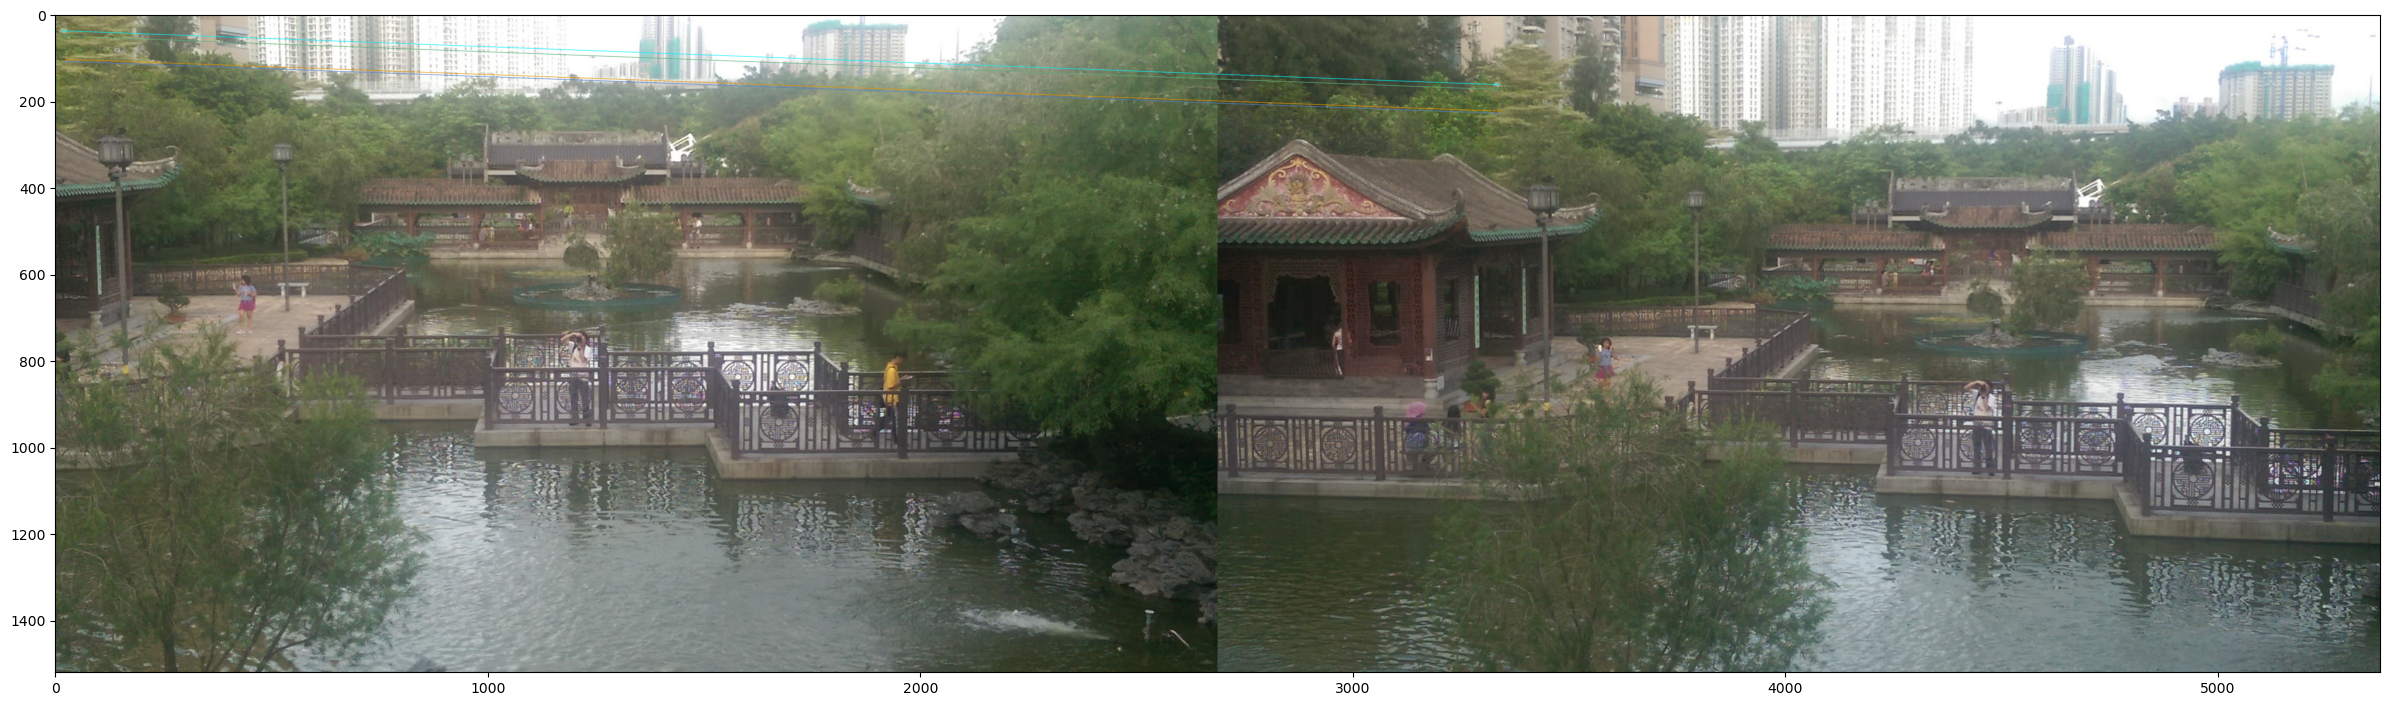

In [13]:
img1, img2 = load_images(images_folder_path)
kp1, kp2 = get_kp_match(img1, img2)
print(homography(kp1, kp2))